In [127]:
nth = Threads.nthreads()

12

In [128]:
using Revise

In [129]:
using PMDPs
using PMDPs.LP
using DrWatson
using RandomNumbers.Xorshifts
using MCTS
using POMDPSimulators
using POMDPPolicies
using DiscreteValueIteration

using Formatting

import Base.show

using Plots
using Distributions
using ProgressMeter


using POMDPs
using DataFrames

using ProgressMeter

using CSV
using Statistics
using StatsBase
using StatsPlots

using Plots.PlotMeasures

In [130]:
RND = Xorshift1024Plus
rnd=RND(426380)
Base.show(io::IO, rnd::Xorshift1024Plus) = print(io, "Xorshift1024Plus")

include(srcdir("MDPPricing.jl"))


get_tiny_benchmarks (generic function with 1 method)

## FIGURE OUT NUMBER OF TIMESTEPS FOR PROBLEMS

In [131]:
# nᵣ = 24
nᵣ = 48
#nᵣ = 72
# nᵣ = 96

expected_res_range = [0.5*nᵣ, 1*nᵣ, 1.5*nᵣ, 2*nᵣ, 2.5*nᵣ, 3*nᵣ, 3.5*nᵣ]
expected_res_range./(3*nᵣ)

T_multipliers = ones(length(expected_res_range))
for (i, expected_res) in enumerate(expected_res_range)
    while true
        # pp_params = get_pp_params(expected_res)
        pp_params = Dict(pairs((
                nᵣ = nᵣ,
                c = 3,
                T = Int64(expected_res*T_multipliers[i]),
                expected_res = expected_res, # keeps the expected demand constant for different numbers of resources, at average 2 per hour-long slot.
                res_budget_μ = 24.0/nᵣ, # assuming nᵣ is number of timeslots in one day, this means that budget remains 1 per hour.
                objective = :utilization,
            )))
        # println("$(i): nᵣ = $(nᵣ)")
        try
            pp = PMDPs.single_day_cs_pp(;pp_params...)
        catch e
            if isa(e, AssertionError)
                # Sprintln("Error: ", e)
                # println("$(i): low multipler $(T_multipliers[i]) for nᵣ $(nᵣ)")
                T_multipliers[i]+=1
                continue
            else
                throw(e)
            end
        end
        break
    end
end
println("The multipliers for getting T are $(T_multipliers) -> $(maximum(T_multipliers))")
T_multiplier = maximum(T_multipliers)

The multipliers for getting T are [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0] -> 2.0


2.0

## PREPARE PROBLEM AND TRACES

In [132]:
OUT_FOLDER = "ev_experiments"

inputs = []
PP_NAME = "cs_var_demand_$(nᵣ)"

# Threads.@threads 
for expected_res in expected_res_range
    # println("\n===Running expected res: $(expected_res)")
    pp_params = Dict(pairs((
            nᵣ = nᵣ,
            c = 3,
            T = Int64(expected_res*T_multiplier),
            expected_res = expected_res, # keeps the expected demand constant for different numbers of resources, at average 2 per hour-long slot.
            res_budget_μ = 24.0/nᵣ, # assuming nᵣ is number of timeslots in one day, this means that budget remains 1 per hour.
            objective = :revenue,
        )))
    # PMDPs.statespace_size(pp)
        
    vi = false
    name = PP_NAME
    n_traces = 1000
    
    # mg = PMDPs.PMDPg(pp)
    # me = PMDPs.PMDPe(pp)
    
    # tr = PMDPs.simulate_trace(PMDPs.PMDPg(pp),RND(1))
    pp = PMDPs.single_day_cs_pp(;pp_params...)
    push!(inputs, PMDPs.prepare_traces(pp, pp_params, vi, name, n_traces; verbose=true, folder = OUT_FOLDER, seed=8888, save=false))

#     upp_params = deepcopy(pp_params)
#     upp_params[:objective]=:utilization
#     upp = PMDPs.single_day_cs_pp(; upp_params...)
#     push!(inputs, PMDPs.prepare_traces(upp, upp_params, vi, name, n_traces; verbose=true, folder = OUT_FOLDER, seed=1))
end

Loading /home/mrkos/projects/MDPPricing/data/ev_experiments/traces/cs_var_demand_48_N=1000_T=48_c=3_expected_res=24.0_nᵣ=48_objective=revenue_res_budget_μ=0.5.jld2
Loading /home/mrkos/projects/MDPPricing/data/ev_experiments/traces/cs_var_demand_48_N=1000_T=96_c=3_expected_res=48.0_nᵣ=48_objective=revenue_res_budget_μ=0.5.jld2
Loading /home/mrkos/projects/MDPPricing/data/ev_experiments/traces/cs_var_demand_48_N=1000_T=144_c=3_expected_res=72.0_nᵣ=48_objective=revenue_res_budget_μ=0.5.jld2
Loading /home/mrkos/projects/MDPPricing/data/ev_experiments/traces/cs_var_demand_48_N=1000_T=192_c=3_expected_res=96.0_nᵣ=48_objective=revenue_res_budget_μ=0.5.jld2
Loading /home/mrkos/projects/MDPPricing/data/ev_experiments/traces/cs_var_demand_48_N=1000_T=240_c=3_expected_res=120.0_nᵣ=48_objective=revenue_res_budget_μ=0.5.jld2
Loading /home/mrkos/projects/MDPPricing/data/ev_experiments/traces/cs_var_demand_48_N=1000_T=288_c=3_expected_res=144.0_nᵣ=48_objective=revenue_res_budget_μ=0.5.jld2
Loading /h

In [133]:
pp = inputs[4][:pp]
mg = PMDPs.PMDPg(pp);

## MCTS solver

In [134]:
params_classical_MCTS = Dict(
    pairs((
        depth = 3,
        exploration_constant = 1.0,
        n_iterations = 1000,
        reuse_tree = false,
        rng = RND(888),
    )),
)

solver = MCTSSolver(;params_classical_MCTS...)
policy = solve(solver, mg);

rng = RND(1)

Xorshift1024Plus

In [135]:
s = rand(initialstate(mg))

c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:1177

In [136]:
products = PMDPs.products(mg)
len_2 = sum.(products).==2
prod = products[len_2][end]

print(prod)

PMDPs.index(mg, prod)

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

95

In [137]:
pp.c₀, pp.T

([3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 192)

In [138]:
actions(mg)

100-element Vector{Float64}:
  0.0
  0.25
  0.5
  0.75
  1.0
  1.25
  1.5
  1.75
  2.0
  2.25
  2.5
  2.75
  3.0
  ⋮
 22.0
 22.25
 22.5
 22.75
 23.0
 23.25
 23.5
 23.75
 24.0
 24.25
 24.5
  1.7976931348623157e308

## Checking Responses

In [139]:
function get_actions_and_repsonses(mg, policy, s, N, rng)
    mcts_actions = Float64[]
    sps = []

    for i in 1:N
        a = action(policy, s)
        sp = PMDPs.gen(mg, s, a, rng)
        push!(sps, (sp..., a=a))
    end
    sps
end


N = 30
t=35
s = PMDPs.State(pp.c₀, t, 80)
sps = get_actions_and_repsonses(mg, policy, s, N, rng)

30-element Vector{Any}:
 (sp = c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:36_p:1177, r = 0.0, info = (b = 1.3457604416442526,), a = 17.0)
 (sp = c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:36_p:1177, r = 0.0, info = (b = 0.8212117759456218,), a = 17.0)
 (sp = c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:36_p:22, r = 0.0, info = (b = 0.7510731832502153,), a = 1.0)
 (sp = c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:36_p:1177, r = 0.0, info = (b = 1.177573151096307,), a = 15.25)
 (sp = c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [140]:
function measure_mcts_response_to_varied_states(states::Vector{PMDPs.State}, mg, policy, N, rng)
    n = length(states)

    a_means = Vector{Float64}(undef,n)
    a_stds = Vector{Float64}(undef,n)
    accepts = Vector{Int64}(undef,n)
    sps_list = Array{Any}(undef,n)

    Threads.@threads for (i, s) in collect(enumerate(states))
        println(s)
        sps = get_actions_and_repsonses(deepcopy(mg), deepcopy(policy), deepcopy(s), N, deepcopy(rng))
        sps_list[i]= sps

        rs = [sp[:r] for sp in sps]
        accepts[i] = sum(rs.>0)

        as = [sp[:a] for sp in sps if sp[:a]<PMDPs.REJECT_ACTION]
        a_means[i] = mean(as)
        a_stds[i] = std(as) 
    end
    return (a_means = a_means, a_stds=a_stds, accepts=accepts, sps_list=sps_list)
end

measure_mcts_response_to_varied_states (generic function with 1 method)

In [141]:
lineplot_kwargs = Dict(pairs((marker=true, alpha=0.99, linewidth=5, thickness_scaling = 1)))

Dict{Symbol, Real} with 4 entries:
  :alpha             => 0.99
  :linewidth         => 5
  :thickness_scaling => 1
  :marker            => true

### Varying request time

with fixed request

In [142]:
products = PMDPs.products(mg)
len_2 = sum.(products).==2
prod = products[len_2][end]

print(prod)

iₚ = PMDPs.index(mg, prod)

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

95

In [143]:
findfirst(products[80])*(24.0 / PMDPs.n_resources(pp))

16.0

In [144]:
# 12 threads: 1m10s
# single thread: 4m40s

N = 100
t = 1
iₚ = 80
c₀ = pp.c₀

t_range = 1:10:pp.T
states = [PMDPs.State(c₀, t, iₚ) for t in t_range]

response_1 = measure_mcts_response_to_varied_states(states, mg, policy, N, rng)

c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:161_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:21_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:141_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:171_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:101_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1msample_request[22m
    [90m    @ [39m[90m~/projects/MDPPricing/src/PMDPs/src/PMDP/[39m[90m[4mPMDP.jl:207[24m[39m[90m [inlined][39m
      [2] [0m[1mgen[22m[0m[1m([22m[90mm[39m::[0mPMDPs.PMDPgr, [90ms[39m::[0mPMDPs.State, [90ma[39m::[0mFloat64, [90mrng[39m::[0mXorshift1024Plus[0m[1m)[22m
    [90m    @ [39m[35mPMDPs[39m [90m~/projects/MDPPricing/src/PMDPs/src/PMDP/[39m[90m[4mPMDPgr.jl:49[24m[39m
      [3] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m~/.julia/packages/POMDPs/PFpk1/src/[39m[90m[4mgen_impl.jl:23[24m[39m[90m [inlined][39m
      [4] [0m[1mgenout[22m
    [90m    @ [39m[90m~/.julia/packages/POMDPs/PFpk1/src/[39m[90m[4mgen_impl.jl:19[24m[39m[90m [inlined][39m
      [5] [0m[1m#61#f[22m
    [90m    @ [39m[90m~/.julia/packages/POMDPs/PFpk1/src/[39m[90m[4mgenerative.jl:65[24m[39m[90m [inlined][39m
      [6] [0m[1msimulate[22m[0m[1m([22m[90msim[39m::[0mRolloutSimulator[90m{Xorshift1024Plus}[39m, [90mmdp[39m::[0mPMDPs.PMDPgr, [90mpolicy[39m::[0mRandomPolicy[90m{Xorshift1024Plus, PMDPs.PMDPg, BeliefUpdaters.NothingUpdater}[39m, [90minitialstate[39m::[0mPMDPs.State[0m[1m)[22m
    [90m    @ [39m[36mPOMDPSimulators[39m [90m~/.julia/packages/POMDPSimulators/zxTz3/src/[39m[90m[4mrollout.jl:169[24m[39m
      [7] [0m[1mrollout[22m
    [90m    @ [39m[90m~/projects/MDPPricing/src/PMDPs/src/PMDP/[39m[90m[4mPMDPgr.jl:59[24m[39m[90m [inlined][39m
      [8] [0m[1mestimate_value[22m
    [90m    @ [39m[90m~/.julia/packages/MCTS/AVGIc/src/[39m[90m[4mdomain_knowledge.jl:49[24m[39m[90m [inlined][39m
      [9] [0m[1msimulate[22m[0m[1m([22m[90mplanner[39m::[0mMCTSPlanner[90m{PMDPs.PMDPg, PMDPs.State, Float64, MCTS.SolvedRolloutEstimator{RandomPolicy{Xorshift1024Plus, PMDPs.PMDPg, BeliefUpdaters.NothingUpdater}, Xorshift1024Plus}, Xorshift1024Plus}[39m, [90mnode[39m::[0mStateNode[90m{PMDPs.State, Float64}[39m, [90mdepth[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[32mMCTS[39m [90m~/.julia/packages/MCTS/AVGIc/src/[39m[90m[4mvanilla.jl:293[24m[39m
     [10] [0m[1msimulate[22m[0m[1m([22m[90mplanner[39m::[0mMCTSPlanner[90m{PMDPs.PMDPg, PMDPs.State, Float64, MCTS.SolvedRolloutEstimator{RandomPolicy{Xorshift1024Plus, PMDPs.PMDPg, BeliefUpdaters.NothingUpdater}, Xorshift1024Plus}, Xorshift1024Plus}[39m, [90mnode[39m::[0mStateNode[90m{PMDPs.State, Float64}[39m, [90mdepth[39m::[0mInt64[0m[1m)[22m[90m (repeats 3 times)[39m
    [90m    @ [39m[32mMCTS[39m [90m~/.julia/packages/MCTS/AVGIc/src/[39m[90m[4mvanilla.jl:309[24m[39m
     [11] [0m[1mbuild_tree[22m[0m[1m([22m[90mplanner[39m::[0mMCTSPlanner[90m{PMDPs.PMDPg, PMDPs.State, Float64, MCTS.SolvedRolloutEstimator{RandomPolicy{Xorshift1024Plus, PMDPs.PMDPg, BeliefUpdaters.NothingUpdater}, Xorshift1024Plus}, Xorshift1024Plus}[39m, [90ms[39m::[0mPMDPs.State[0m[1m)[22m
    [90m    @ [39m[32mMCTS[39m [90m~/.julia/packages/MCTS/AVGIc/src/[39m[90m[4mvanilla.jl:274[24m[39m
     [12] [0m[1mplan![22m
    [90m    @ [39m[90m~/.julia/packages/MCTS/AVGIc/src/[39m[90m[4mvanilla.jl:248[24m[39m[90m [inlined][39m
     [13] [0m[1maction_info[22m[0m[1m([22m[90mp[39m::[0mMCTSPlanner[90m{PMDPs.PMDPg, PMDPs.State, Float64, MCTS.SolvedRolloutEstimator{RandomPolicy{Xorshift1024Plus, PMDPs.PMDPg, BeliefUpdaters.NothingUpdater}, Xorshift1024Plus}, Xorshift1024Plus}[39m, [90ms[39m::[0mPMDPs.State[0m[1m)[22m
    [90m    @ [39m[32mMCTS[39m [90m~/.julia/packages/MCTS/AVGIc/src/[39m[90m[4mvanilla.jl:203[24m[39m
     [14] [0m[1maction[22m
    [90m    @ [39m[90m~/.julia/packages/MCTS/AVGIc/src/[39m[90m[4mvanilla.jl:208[24m[39m[90m [inlined][39m
     [15] [0m[1mget_actions_and_repsonses[22m[0m[1m([22m[90mmg[39m::[0mPMDPs.PMDPg, [90mpolicy[39m::[0mMCTSPlanner[90m{PMDPs.PMDPg, PMDPs.State, Float64, MCTS.SolvedRolloutEstimator{RandomPolicy{Xorshift1024Plus, PMDPs.PMDPg, BeliefUpdaters.NothingUpdater}, Xorshift1024Plus}, Xorshift1024Plus}[39m, [90ms[39m::[0mPMDPs.State, [90mN[39m::[0mInt64, [90mrng[39m::[0mXorshift1024Plus[0m[1m)[22m
    [90m    @ [39m[33mMain[39m [90m./[39m[90m[4mIn[139]:6[24m[39m
     [16] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90m[4mIn[140]:11[24m[39m[90m [inlined][39m
     [17] [0m[1m(::var"#308#threadsfor_fun#155"{PMDPs.PMDPg, MCTSPlanner{PMDPs.PMDPg, PMDPs.State, Float64, MCTS.SolvedRolloutEstimator{RandomPolicy{Xorshift1024Plus, PMDPs.PMDPg, BeliefUpdaters.NothingUpdater}, Xorshift1024Plus}, Xorshift1024Plus}, Int64, Xorshift1024Plus, Vector{Any}, Vector{Int64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{Int64, PMDPs.State}}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[33mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [18] [0m[1m(::var"#308#threadsfor_fun#155"{PMDPs.PMDPg, MCTSPlanner{PMDPs.PMDPg, PMDPs.State, Float64, MCTS.SolvedRolloutEstimator{RandomPolicy{Xorshift1024Plus, PMDPs.PMDPg, BeliefUpdaters.NothingUpdater}, Xorshift1024Plus}, Xorshift1024Plus}, Int64, Xorshift1024Plus, Vector{Any}, Vector{Int64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{Int64, PMDPs.State}}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[33mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [145]:
# s = PMDPs.State(c₀, 130, iₚ )
# a = action(policy, s)
# println(s)
# println("a: $a")
# sp = PMDPs.gen(mg, s, a, rng)

In [146]:
(a_means, a_stds, accepts, sps_list) = deepcopy(response_1);

In [147]:
n_timesteps = pp.T
timestep_length = 24. / n_timesteps

# prod = prod_range[3]
# starting_hour = (findfirst(prod)-1)*timeslot_length

request_hour = [ts*timestep_length for ts in t_range];

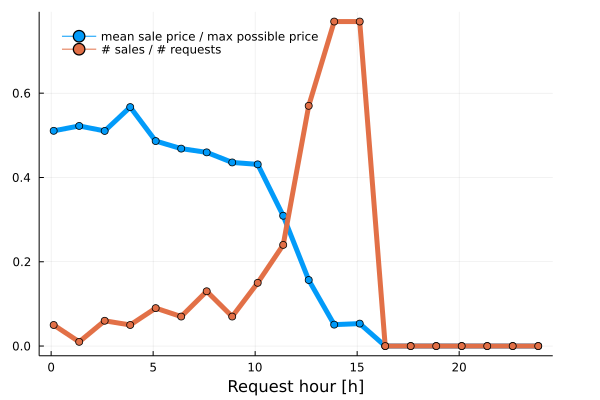

In [148]:
p = plot(legend=:topleft, foreground_color_legend = nothing,background_color_legend=nothing, xrotation=0, right_margin=10mm)
plot!(p, request_hour, a_means ./ actions(mg)[end-1]; label="mean sale price / max possible price", lineplot_kwargs...)
# p2 = twinx(p)
plot!(p, request_hour, accepts ./ N; label="# sales / # requests", lineplot_kwargs...)

xlabel!(p,  "Request hour [h]")
# ylabel!(p,  "mean offered per-minute price [1/min]")
# ylabel!(p2, "# of sales [1]")

display(p)
savefig(p, "fig_price_response_var_request_time.pdf")

### Moving request throughout the day
with fixed request length

In [110]:
products = PMDPs.products(mg)
len_2 = sum.(products).==2
prods = products[len_2]
prod_ids = [PMDPs.index(mg, prod) for prod in prods]


N = 100
t = 1
iₚ = 80
c₀ = pp.c₀ .- 2
# s = PMDPs.State(c₀, t, iₚ )


pid_range = prod_ids[begin:3:end]
states = [PMDPs.State(c₀, t, iₚ) for iₚ in pid_range]

response_2 = measure_mcts_response_to_varied_states(states, mg, policy, N, rng)

c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:1_p:49
c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:1_p:52
c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:1_p:88
c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:1_p:76
c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:1_p:85
c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:1_p:94
c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

(a_means = [10.722222222222221, 10.487373737373737, 8.115, 10.547979797979798, 10.934343434343434, 11.855, 12.01, 12.308080808080808, 12.931818181818182, 13.242424242424242, 13.209183673469388, 11.679292929292929, 13.025, 13.244949494949495, 13.05050505050505, 11.0375], a_stds = [7.973720299803671, 8.005528521585285, 7.292969147740788, 7.879244626050059, 7.894277979627067, 7.097728687774176, 6.838405360812408, 6.727838552257341, 6.9664665250150914, 7.0011346151759195, 6.45480859250809, 6.792293840625454, 6.388861440432913, 7.192149542970003, 7.0059176697547905, 7.462648996871356], accepts = [12, 14, 17, 10, 10, 3, 1, 0, 0, 0, 2, 0, 0, 0, 3, 5], sps_list = Any[Any[(sp = c:[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:2_p:1177, r = 1.5, info = (b = 0.8389967388180167,), a = 0.75), (sp = c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [149]:
(a_means, a_stds, accepts, sps_list) = deepcopy(response_2);

c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:151_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:131_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:111_p:80


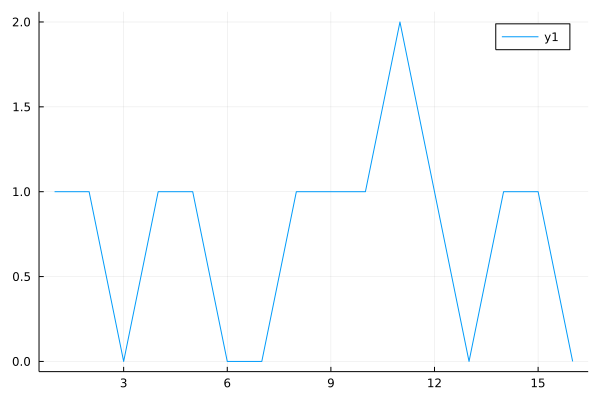

In [150]:
plot([sum([s[:a] for s in sps] .== PMDPs.REJECT_ACTION) for sps in sps_list])

In [151]:
prod_range = PMDPs.products(mg)[pid_range]
timeslot_length = 24. / PMDPs.n_resources(pp)

# prod = prod_range[3]
# starting_hour = (findfirst(prod)-1)*timeslot_length

start_hours = [(findfirst(prod)-1)*timeslot_length for prod in prod_range]

16-element Vector{Float64}:
  0.0
  1.5
  3.0
  4.5
  6.0
  7.5
  9.0
 10.5
 12.0
 13.5
 15.0
 16.5
 18.0
 19.5
 21.0
 22.5

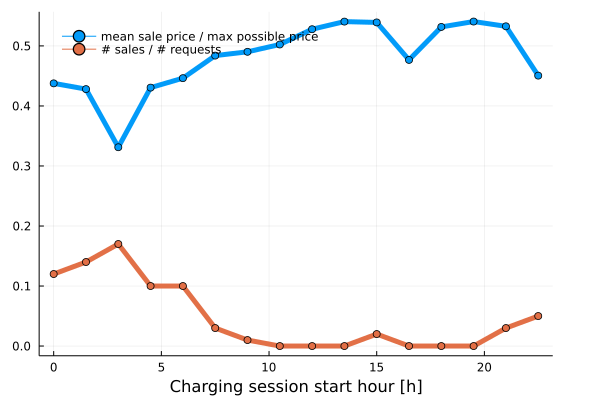

In [152]:
p = plot(legend=:topleft, foreground_color_legend = nothing,background_color_legend=nothing, xrotation=0, right_margin=10mm)
plot!(p, start_hours, a_means ./ actions(mg)[end-1]; label="mean sale price / max possible price", lineplot_kwargs...)
# p2 = twinx(p)
plot!(p, start_hours, accepts ./ N; label="# sales / # requests", lineplot_kwargs...)

xlabel!(p,  "Charging session start hour [h]")
# ylabel!(p,  "mean offered per-minute price [1/min]")
# ylabel!(p2, "# of sales [1]")

display(p)
savefig(p, "fig_price_response_var_start_time.pdf")

### Varying request length
with request charging ending at the end of the selling period

In [76]:
products = PMDPs.products(mg)
end_at_end_prods = [p[end] for p in products]
prods = products[end_at_end_prods]

prod_ids = [PMDPs.index(mg, prod) for prod in prods]

48-element Vector{Int64}:
   48
   95
  141
  186
  230
  273
  315
  356
  396
  435
  473
  510
  546
    ⋮
 1110
 1121
 1131
 1140
 1148
 1155
 1161
 1166
 1170
 1173
 1175
 1176

In [72]:
N = 100

t = 1
iₚ = 80
c₀ = pp.c₀
s = PMDPs.State(c₀, t, iₚ )



pid_range_3 = prod_ids[begin:3:end]
states = [PMDPs.State(c₀, t, iₚ) for iₚ in pid_range_3]

response_3 = measure_mcts_response_to_varied_states(states, mg, policy, N, rng)

c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:315
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:1023
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:900
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:1071
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:1140
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:48
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

(a_means = [12.765151515151516, 8.1, 2.8525, 4.2325, 5.81, 7.29, 8.775, 10.365, 11.8125, 13.2975, 14.8025, 16.3325, 17.8175, 19.315, 20.7725, 22.255], a_stds = [6.737688903661492, 8.229044398784815, 1.1465225200094802, 0.37981753992721773, 0.35018032872544774, 0.28364510476041266, 0.24230584229877994, 0.19273418131318754, 0.2143082599972066, 0.17658016750347574, 0.16778036990438577, 0.1509858177833838, 0.13695368973238045, 0.17269404252385873, 0.15527346355655394, 0.12801909579781012], accepts = [0, 36, 93, 96, 94, 100, 100, 99, 99, 99, 99, 99, 100, 100, 100, 100], sps_list = Any[Any[(sp = c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:2_p:1177, r = 0.0, info = (b = 0.33899673881801673,), a = 1.25), (sp = c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:2_p:77, r = 0.0, info = (b = 0.125

In [153]:
(a_means, a_stds, accepts, sps_list) = deepcopy(response_3);

c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:91_p:80


In [154]:
prod_range = PMDPs.products(mg)[pid_range_3]
timeslot_length = 24. / PMDPs.n_resources(pp)

# prod = prod_range[3]
# starting_hour = (findfirst(prod)-1)*timeslot_length

prod_length = [sum(prod)*timeslot_length for prod in prod_range]

c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:71_p:80


16-element Vector{Float64}:
  0.5
  2.0
  3.5
  5.0
  6.5
  8.0
  9.5
 11.0
 12.5
 14.0
 15.5
 17.0
 18.5
 20.0
 21.5
 23.0

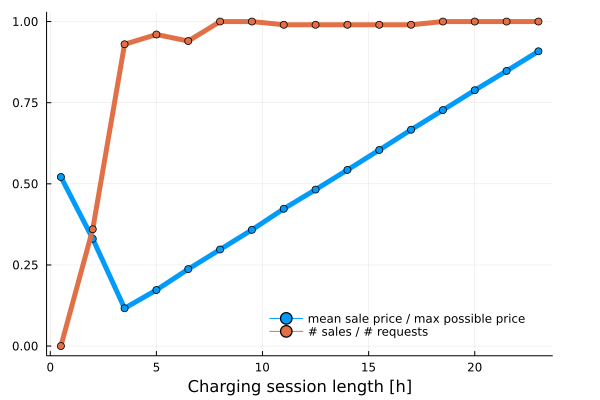

In [155]:
p = plot(legend=:bottomright, foreground_color_legend = nothing,background_color_legend=nothing, xrotation=0, right_margin=10mm)
plot!(p, prod_length, a_means ./ actions(mg)[end-1]; label="mean sale price / max possible price", lineplot_kwargs...)
# p2 = twinx(p)
plot!(p, prod_length, accepts ./ N; label="# sales / # requests", lineplot_kwargs...)

xlabel!(p,  "Charging session length [h]")
# ylabel!(p,  "mean offered per-minute price [1/min]")
# ylabel!(p2, "# of sales [1]")

display(p)
savefig(p, "fig_price_response_var_request_length.pdf")

### Varying initial capacity
from 1 to 6

In [95]:
N = 100

t = 1
iₚ = 80
c₀ = pp.c₀
s = PMDPs.State(c₀, t, iₚ )



cpc_range = 1:6
states = [PMDPs.State(c .* ones(Int64, length(pp.c₀)), t, iₚ) for c in cpc_range]

response_4 = measure_mcts_response_to_varied_states(states, mg, policy, N, rng)

c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:1_p:80
c:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]_t:1_p:80
c:[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]_t:1_p:80
c:[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]_t:1_p:80
c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:1_p:80
c:[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]_t:1_p:80


(a_means = [13.358585858585858, 11.843434343434344, 12.5125, 11.9775, 12.186868686868687, 12.487373737373737], a_stds = [6.401845398821361, 7.5750989973481415, 6.666418082486655, 7.216361792846346, 7.624924174459336, 7.858634090416626], accepts = [1, 4, 5, 7, 2, 2], sps_list = Any[Any[(sp = c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:2_p:1177, r = 0.0, info = (b = 0.8389967388180167,), a = 21.75), (sp = c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:2_p:77, r = 0.0, info = (b = 0.6254217164369793,), a = 9.75), (sp = c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]_t:2_p:111, r = 0.0, info = (b = 1.141570673556845,), a = 19.0), (sp = c:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [156]:
(a_means, a_stds, accepts, sps_list) = deepcopy(response_4);
xrange = cpc_range

c:[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]_t:51_p:80


1:6

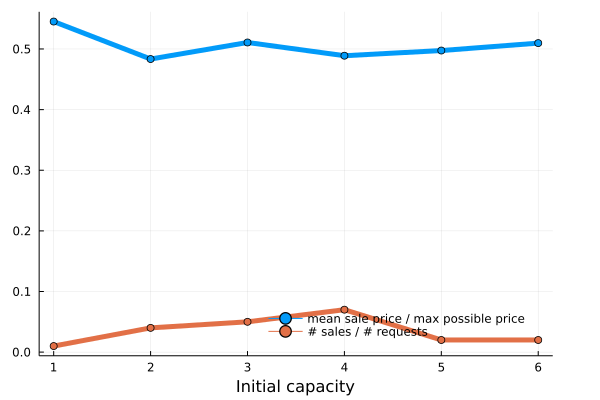

In [157]:
p = plot(legend=:bottomright, foreground_color_legend = nothing,background_color_legend=nothing, xrotation=0, right_margin=10mm)
plot!(p, xrange, a_means ./ actions(mg)[end-1]; label="mean sale price / max possible price", lineplot_kwargs...)
# p2 = twinx(p)
plot!(p, xrange, accepts ./ N; label="# sales / # requests", lineplot_kwargs...)

xlabel!(p,  "Initial capacity")
# ylabel!(p,  "mean offered per-minute price [1/min]")
# ylabel!(p2, "# of sales [1]")

display(p)
savefig(p, "fig_price_response_var_initial_capacity.pdf")